In [104]:
import mnist_loader
import network
import numpy as np
from matplotlib import pyplot as plt

In [103]:
training_data, validation_data, test_data,train_ae,val_ae,test_ae = mnist_loader.load_data_wrapper(make_binary =True)

In [309]:
net = network.Network([784, 30, 10], cost=network.CrossEntropyCost)
net.large_weight_initializer()
net.SGD(training_data, 5, 10, 0.5)


Epoch 0 training complete

Epoch 1 training complete

Epoch 2 training complete

Epoch 3 training complete

Epoch 4 training complete



([], [], [], [])

In [106]:
test_in = np.transpose([np.squeeze(i[0]) for i in test_data])
posteriors = net.feedforward(test_in)
test_pred = np.argmax(posteriors,0)

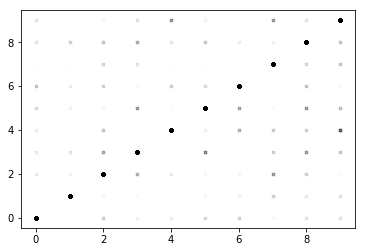

In [107]:
test_out = [i[1] for i in test_data]
plt.plot(test_out,test_pred,'k.',alpha=.01)
plt.show()

# Try autoendoder Network

In [108]:
net_ae = network.Network([784,30,5,30,784], cost=network.QuadraticCost)
net_ae.large_weight_initializer()
net_ae.SGD(train_ae, 10, 10, 0.5,evaluation_data=val_ae)

Epoch 0 training complete

Epoch 1 training complete

Epoch 2 training complete

Epoch 3 training complete

Epoch 4 training complete

Epoch 5 training complete

Epoch 6 training complete

Epoch 7 training complete

Epoch 8 training complete

Epoch 9 training complete



([], [], [], [])

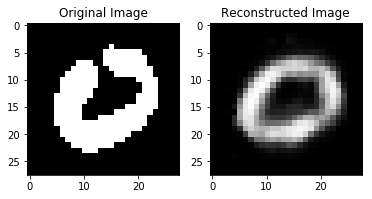

In [112]:
in_dat  = test_ae[25][0]
out_dat = net_ae.feedforward(in_dat)

plt.subplot(1,2,1)
plt.imshow(np.reshape(in_dat,(28,28)),cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(np.reshape(out_dat,(28,28)),cmap='gray')
plt.title('Reconstructed Image')
plt.show()


In [11]:
wts = net_ae.weights
bias = net_ae.biases
np.shape(wts[3]) # (4,): [0] (30,784), [1] (5,30), [2] (30,5), [3] (784,30)
np.shape(bias[3])# (4,):[0] (30,1), [1] (5,1), [2] (30,1), [3] (784,1)

(784, 1)

In [255]:
decoder_wts = wts[2:]
decoder_bias = bias[2:]
encoder_wts = wts[0:2]
encoder_bias = bias[0:2]
# print(np.shape(decoder_wts[1]))

def use_decode(wts,bias,a):
    for b, w in zip(bias, wts):
        a = sigmoid(np.dot(w, a)+b)
    return a

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def encode_decode(wts,bias,in_val):
    n_bottleneck = len(wts[2][1]) # assuming 5 layer NN
    n_layer = len(wts)
    n_trials = len(in_val)
    n_dim = np.shape(test_ae)[2]
    bot_val = np.zeros((n_trials,n_bottleneck))
    img_out = np.zeros((n_trials,n_dim))

    for i in range(len(in_val)):
        a = in_val[i][0]
        for ii in range(n_layer):
            a = sigmoid(np.dot(wts[ii],a)+bias[ii])
            if ii == 1:
                #print(np.shape(a))
                bot_val[i,:] = np.squeeze(a)
            if ii == n_layer-1:
                img_out[i,:] = np.squeeze(a)
    return bot_val, img_out
                

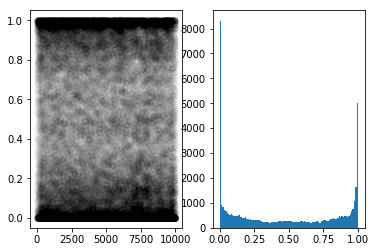

In [256]:
b_val,img_out = encode_decode(wts,bias,test_ae[:10000])
plt.subplot(1,2,1)
plt.plot(b_val,'ko',alpha=.01)
plt.subplot(1,2,2)
f_val = b_val.flatten()
plt.hist(foo,100)
plt.show()

In [273]:
# bool central layer, then compute entropy
b_val_bool = (b_val>.5)*1
avg_val = np.mean(b_val_bool,0)
bin_ent(avg_val)

array([ 0.93758975,  0.99999351,  0.99890255,  0.99086738,  0.99982892])

In [303]:
foo = dat_eval_net[0][0]
bar = dat_eval_net[0][1]
bar

7

In [311]:
# check accuracy of output
np.shape(img_out)
img_out_b = (img_out>.5)*1
np.shape(test_data[1])
dat_eval_net = zip(img_out_b,test_out)
# foo = net.accuracy(dat_eval_net)
tmp = net.feedforward(img_out_b[10])
np.shape(tmp)

(10, 30)

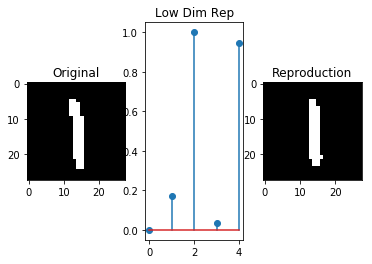

In [294]:
# in_probe = np.array([0, 0,0, 0, 0])
in_dat  = test_ae[37][0]
cent = use_decode(encoder_wts,encoder_bias,in_dat)
in_probe = cent
tmp_out = use_decode(decoder_wts,decoder_bias,in_probe)
tmp2 = tmp_out
tmp2 = (tmp2>.5)*1
np.shape(tmp2)

plt.subplot(1,3,1)
plt.imshow(np.reshape(in_dat,(28,28)),cmap='gray')
plt.title('Original')
plt.subplot(1,3,2)
plt.stem(cent)
plt.title('Low Dim Rep')
plt.subplot(1,3,3)
plt.imshow(np.reshape(tmp2,(28,28)),cmap='gray')
plt.title('Reproduction')
plt.show()

# compute entropy

/home/AD/tsheehan/anaconda3/envs/mne/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
/home/AD/tsheehan/anaconda3/envs/mne/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


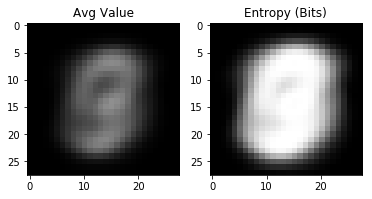

In [181]:
# now that it is binary simply compute 
foo = training_data
x = [i[0] for i in training_data]
x_avg = np.mean(x,0)
x_ent = bin_ent(x_avg)
plt.subplot(1,2,1)
plt.imshow(np.reshape(x_avg,(28,28)),vmin=0, vmax=1,cmap='gray')
plt.title('Avg Value')
plt.subplot(1,2,2)
plt.imshow(np.reshape(x_ent,(28,28)),vmin=0, vmax=1,cmap='gray')
plt.title('Entropy (Bits)')
plt.show()

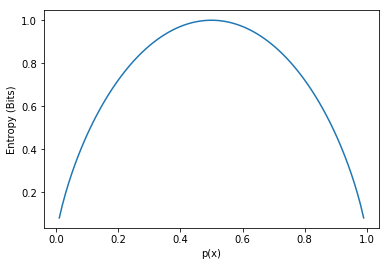

In [175]:
def bin_ent(p): 
    ent = -(p*np.log2(p)+(1-p)*np.log2(1-p))
    ent[np.isnan(ent)]=0
    return ent
x = np.arange(0.01,1,.01)
plt.plot(x,bin_ent(x))
plt.xlabel('p(x)')
plt.ylabel('Entropy (Bits)')
plt.show()

In [93]:
foo = list(map(lambda x:(x>.5)*1,t_in))